# Autoencoder-based FDIA Detection on PMU Data

This notebook trains and evaluates an **Autoencoder** for unsupervised FDIA detection.

**Dataset:** `data/processed/pmu_with_fdia.csv`

## 1. Load and Preprocess the Dataset

- Keep only numerical features (drop `timestamp`, `label` initially)
- Normalize features (MinMaxScaler or StandardScaler)
- Split data: train only on normal samples (`label=0`), test on all

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('../data/processed/pmu_with_fdia.csv')
features = [col for col in df.columns if col not in ['timestamp', 'label']]
X = df[features].values
y = df['label'].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split: train only on normal
X_train = X_scaled[y == 0]
X_test = X_scaled
y_test = y

## 2. Build the Anomaly Detection Model

- Use scikit-learn's IsolationForest for unsupervised anomaly detection 

In [3]:
from sklearn.ensemble import IsolationForest

# Build IsolationForest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X_train)

# Predict anomaly scores (lower = more anomalous)
scores = iso_forest.decision_function(X_test)
preds = iso_forest.predict(X_test)
# Convert to 0=normal, 1=anomaly
preds = (preds == -1).astype(int)

## 3. Train the IsolationForest Model

The model is fit on normal data. No separate training/validation loss plot is needed for IsolationForest.

In [4]:
# (No training loop needed for IsolationForest)

## 4. Use Anomaly Scores to Detect Anomalies

In [5]:
# Use IsolationForest anomaly scores to set a threshold
import numpy as np

# Use 5th percentile of normal scores as threshold (lower = more anomalous)
score_threshold = np.percentile(scores[y_test == 0], 5)
# Predict: 0=normal, 1=anomaly
preds_threshold = (scores < score_threshold).astype(int)

## 5. Evaluate Detection Performance

Confusion Matrix (all anomalies):
[[ 82080   4320]
 [235310  39137]]
              precision    recall  f1-score   support

      Normal       0.26      0.95      0.41     86400
     Anomaly       0.90      0.14      0.25    274447

    accuracy                           0.34    360847
   macro avg       0.58      0.55      0.33    360847
weighted avg       0.75      0.34      0.28    360847

FDIA vs Fault:
--- Fault ---
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95     86400
       Fault       0.71      0.69      0.70     15247

    accuracy                           0.91    101647
   macro avg       0.83      0.82      0.82    101647
weighted avg       0.91      0.91      0.91    101647

--- FDIA ---
              precision    recall  f1-score   support

      Normal       0.26      0.95      0.41     86400
     Anomaly       0.90      0.14      0.25    274447

    accuracy                           0.34    360847
   macro avg     

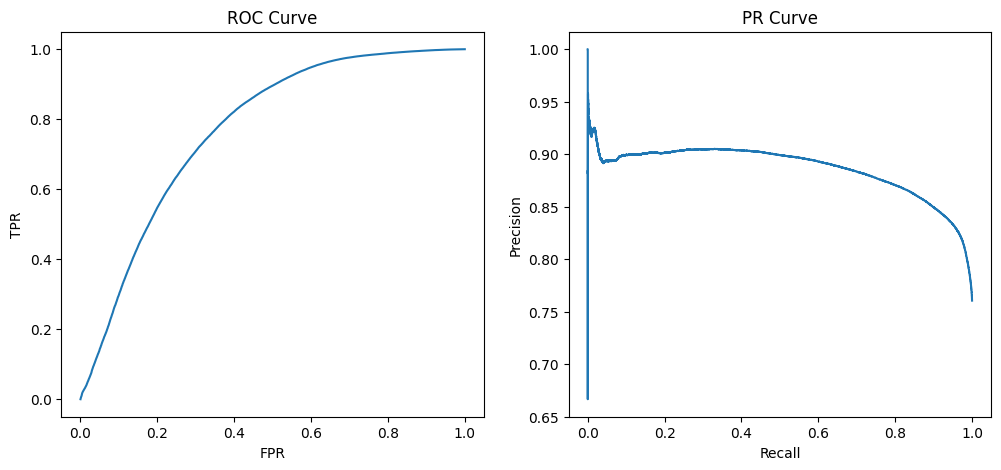

In [6]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# Map y_test: 0=normal, 1=fault, 2=FDIA
print('Confusion Matrix (all anomalies):')
print(confusion_matrix(y_test != 0, preds_threshold))
print(classification_report(y_test != 0, preds_threshold, target_names=['Normal', 'Anomaly']))

# Separate metrics for FDIA vs Fault
print('FDIA vs Fault:')
for label, name in [(1, 'Fault'), (2, 'FDIA')]:
    mask = (y_test == 0) | (y_test == label)
    print(f'--- {name} ---')
    print(classification_report(y_test[mask] == label, preds_threshold[mask], target_names=['Normal', name]))

# ROC and PR curves
fpr, tpr, _ = roc_curve(y_test != 0, -scores)  # Lower scores = more anomalous
precision, recall, _ = precision_recall_curve(y_test != 0, -scores)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(fpr, tpr); plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.subplot(1,2,2); plt.plot(recall, precision); plt.title('PR Curve'); plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

## 7. Visualize Top-N Anomalous Samples

Show the samples with the lowest anomaly scores (most anomalous).

In [8]:
N = 10
top_idx = np.argsort(scores)[:N]  # Most negative = most anomalous
print('Top-N samples with lowest anomaly scores (most anomalous):')
display(df.iloc[top_idx][['timestamp', 'label'] + features])

Top-N samples with lowest anomaly scores (most anomalous):


,timestamp,label,delay_at_arrival,frequency,df/dt,V_a_mag,V_a_ang,I_a_mag,I_a_ang,V_b_mag,V_b_ang,I_b_mag,I_b_ang,V_c_mag,V_c_ang,I_c_mag,I_c_ang
255956,23546,2,0.043900,52.353033,-0.573821,11918.56738,-2.880211,1.347917,-0.809713,11942.35547,1.310874,1.066926,-2.807814,11901.03027,-0.778852,1.286095,1.507451
314341,23546,2,0.043900,49.998405,-0.573921,11918.56738,-2.880211,0.000000,0.000000,11942.35547,1.310874,1.066926,-2.807814,11901.03027,-0.778852,1.286095,1.507451
84705,23546,0,0.043900,49.998405,-0.573921,11918.56738,-2.880211,1.347917,-0.809713,11942.35547,1.310874,1.066926,-2.807814,11901.03027,-0.778852,1.286095,1.507451
267154,23546,2,0.043900,49.998405,-0.573921,11918.56738,-3.486275,1.347917,-0.809713,11942.35547,0.462099,1.066926,-2.807814,11901.03027,-0.750958,1.286095,1.507451
283806,22675,2,0.042898,52.228357,-3.061512,11867.72070,2.552202,1.385995,-1.366364,11896.27930,0.460299,1.076532,3.092332,11854.83691,-1.629843,1.481811,1.008960
356641,22675,2,0.042898,49.960831,-3.061612,11867.72070,2.552202,0.000000,0.000000,11896.27930,0.460299,1.076532,3.092332,11854.83691,-1.629843,1.481811,1.008960
129326,22675,0,0.042898,49.960831,-3.061612,11867.72070,2.552202,1.385995,-1.366364,11896.27930,0.460299,1.076532,3.092332,11854.83691,-1.629843,1.481811,1.008960
329717,22675,2,0.042898,49.960831,-3.061612,11867.72070,2.106573,1.385995,-1.366364,11896.27930,-0.912142,1.076532,3.092332,11854.83691,-2.603166,1.481811,1.008960
108421,5919,2,0.040526,50.571002,0.418000,11889.03125,-1.257694,1.399777,-0.007474,11912.08887,2.932682,1.046707,-2.822225,11861.24219,0.843420,0.525704,2.418214
286219,29993,2,0.043427,49.974525,-0.005077,12005.50586,1.256958,12.708713,1.530889,12031.47754,-3.428281,13.043199,-0.620349,11987.59863,-1.105353,12.285750,-2.713478


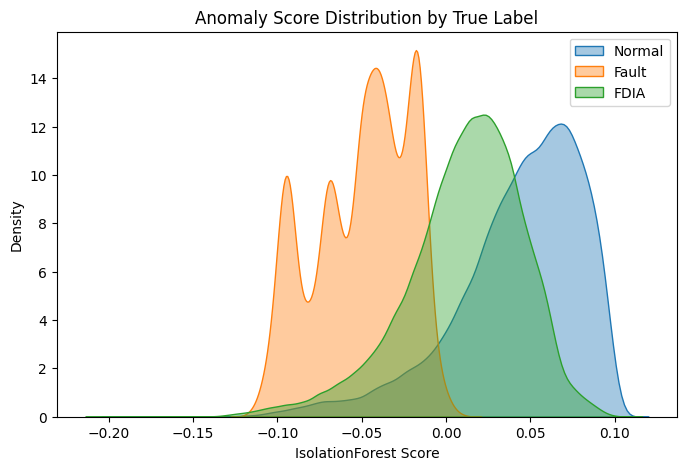

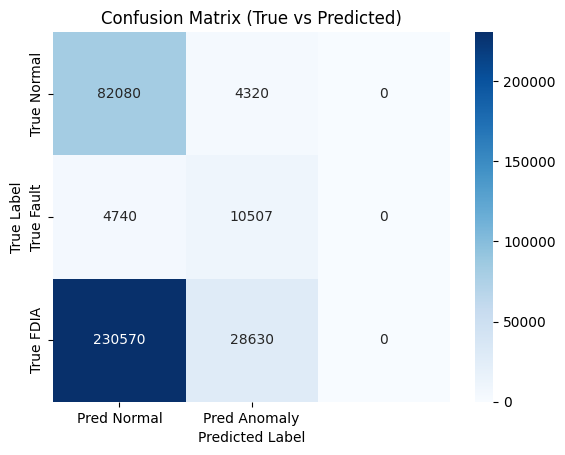

IsolationForest does not provide feature importances.
Overall anomaly detection accuracy: 0.336
Model may need improvement (accuracy <= 0.8).


In [9]:
# Additional plots for model evaluation
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Anomaly score distribution by true label
plt.figure(figsize=(8,5))
for label, name in [(0, 'Normal'), (1, 'Fault'), (2, 'FDIA')]:
    sns.kdeplot(scores[y_test == label], label=name, fill=True, alpha=0.4)
plt.title('Anomaly Score Distribution by True Label')
plt.xlabel('IsolationForest Score')
plt.legend()
plt.show()

# 2. Confusion matrix heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds_threshold, labels=[0,1,2])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Normal','Pred Anomaly'], yticklabels=['True Normal','True Fault','True FDIA'])
plt.title('Confusion Matrix (True vs Predicted)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Show feature importances if available
if hasattr(iso_forest, 'feature_importances_'):
    importances = iso_forest.feature_importances_
    plt.figure(figsize=(10,4))
    sns.barplot(x=features, y=importances)
    plt.title('Feature Importances (IsolationForest)')
    plt.xticks(rotation=45)
    plt.show()
else:
    print('IsolationForest does not provide feature importances.')

# 4. Print model performance summary
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test != 0, preds_threshold)
print(f'Overall anomaly detection accuracy: {acc:.3f}')
if acc > 0.8:
    print('Model is working well (accuracy > 0.8).')
else:
    print('Model may need improvement (accuracy <= 0.8).')